In [38]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from scipy.spatial.distance import cdist #for euclidean distance of consistency t
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from sklearn.preprocessing import normalize
import uuid #to generate random id

#test equal variance
from scipy.stats import levene

#clustering
from sklearn.cluster import AgglomerativeClustering 

#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#interpolate curves for clustering among birds with not exact same days tracked
#from scipy.interpolate import interp1d

#modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, cohen_kappa_score, r2_score,\
mean_squared_error, mean_absolute_error, explained_variance_score#catboost, for a better support of categorical data
from catboost import CatBoostClassifier, Pool
from scipy.stats import pearsonr
import scipy.stats as stats


#PCA
from sklearn import decomposition

#clustering
from sklearn.cluster import KMeans #only numerical var
from sklearn.metrics import silhouette_samples, silhouette_score
import kmodes
from kmodes.kmodes import KModes #with categorical var as well


#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, sampen, chi2_distance, ts_visual, time_series_henColumn_tsRow
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Define parameters

In [40]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
li_binmn = config.li_binmn
pal_class_treat = config.pal_class_treat
pal_treat = config.pal_treat
pal_class = config.pal_class
pal_interintre_treatment = config.pal_interintre_treatment
max_date_adaptability = config.max_date_adaptability
dico_pen_tr = config.dico_pen_tr
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
path_extracted_data_visual_corr = os.path.join(path_extracted_data,'visual','correlation')
path_extracted_data_visual_adap = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability')
path_extracted_data_visual_adap_MVTCLUSTER_tsvisual = os.path.join(path_extracted_data_visual_adap,'MVTCLUSTERING','tsvisual')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual_adap_MVTCLUSTER_tsvisual):
    os.makedirs(path_extracted_data_visual_adap_MVTCLUSTER_tsvisual)

change the configuration file if not done yet!


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
rv = 0

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download variables

In [5]:
#distance measure (chi2, dtw)
df_interintra = pd.read_csv(os.path.join(path_extracted_data_visual_adap ,id_run+'_df_interintra.csv'), sep=';', 
                      parse_dates=['level','level+1'], dayfirst=True)
#weeks of age starting on the first day where the bird was here during 24h
df_interintra['weeks_in_laying_barn'] = df_interintra['DOA'].map(lambda x: int((x-119)/7)+1)
display(df_interintra[['level','DOA','weeks_in_laying_barn']].drop_duplicates().reset_index().head(3))
#remove weeks_in_laying_barn to avoid confusions
df_interintra.drop(['WOA'],inplace=True,axis=1)
li_selected_hens = list(df_interintra['henID1'].unique())
df_interintra['DTW_15_all'] = df_interintra[['DTW_15_1_Zone', 'DTW_15_2_Zone', 'DTW_15_3_Zone','DTW_15_4_Zone','DTW_15_5_Zone']].sum(axis=1)
df_interintra_all = df_interintra.copy()
print(df_interintra.shape)
df_interintra.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,level,DOA,weeks_in_laying_barn
0,0,2020-09-30,119,1
1,931,2020-10-01,120,1
2,2983,2020-10-02,121,1


(91591, 92)


,level,level+1,henID1,henID2,PenID,Treatment,dur_values_normalized_henID1,dur_values_normalized_henID2,chi2distance,DOA,...,DTW_30_1_Zone,nbr_obs_l1_30_1_Zone,nbr_obs_l2_30_1_Zone,is_same_ind,type,HenID1_CLASS,HenID2_CLASS,CLASS,weeks_in_laying_barn,DTW_15_all
0,2020-09-30,2020-10-01,hen_102,hen_102,3,OFH,"[0.0, 0.010625, 0.19631944444444444, 0.0215625...","[0.0, 0.0, 0.0, 0.0, 1.0]",0.128991,119,...,0.0,43,48,True,Intra individuals - OFH,MEXP,MEXP,MEXP,1,135.9
1,2020-09-30,2020-10-01,hen_65,hen_139,10,TRAN,"[0.0, 0.7292708333333333, 0.2707291666666667, ...","[0.0, 0.10932098765432098, 0.06469135802469136...",0.705432,119,...,0.0,44,48,False,Inter individuals - TRAN,LEXP,EPI,LEXPEPI,1,298.8
2,2020-09-30,2020-10-01,hen_65,hen_140,10,TRAN,"[0.0, 0.7292708333333333, 0.2707291666666667, ...","[0.0, 0.03740740740740741, 0.238179012345679, ...",0.675422,119,...,0.0,44,48,False,Inter individuals - TRAN,LEXP,LEXP,LEXP,1,279.0


In [6]:
#daily variables (one row per (henID, date))
df_daily = pd.read_csv(os.path.join(path_extracted_data, 'daily_ALL_Variable_Tranformed.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True) 
df_daily['DOA'] = df_daily['level'].map(lambda x: (x-dt.datetime(2020,6,3)).days) 
df_daily['weeks_in_laying_barn'] = df_daily['DOA'].map(lambda x: int((x-119)/7)+1)
#df_daily['weeks_in_laying_barn'] = df_daily['DOA'].map(lambda x: math.ceil(x/7))
#first two month seems good from the %of hens not moving plot! and sounds good too (twice longer thatn they need to start moving)
print(df_daily.shape)

#filter by dates
df_daily = df_daily[df_daily['level']<=max_date_adaptability] 
df_daily = df_daily[df_daily['level']>dt.datetime(2020,9,29)]

#filter the selected hens
df_daily = df_daily[df_daily['HenID'].isin(li_selected_hens)] 
print(df_daily.shape)
df_daily.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(24452, 195)
(6503, 195)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,clustering_ALL,weeks_in_laying_barn
4,hen_131,2020-09-30,0.0,24385.0,4415.0,0.0,0.0,28800.0,"[0.0, 24385.0, 4415.0, 0.0, 0.0]","[0.0, 0.8467013888888889, 0.15329861111111112,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,hen_131,2020-10-01,0.0,22511.0,5946.0,0.0,3943.0,32400.0,"[0.0, 22511.0, 5946.0, 0.0, 3943.0]","[0.0, 0.6947839506172839, 0.18351851851851853,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,hen_131,2020-10-02,0.0,9266.0,4598.0,1127.0,17409.0,32400.0,"[0.0, 9266.0, 4598.0, 1127.0, 17409.0]","[0.0, 0.28598765432098766, 0.14191358024691358...",...,4.230735,-0.136035,-1.38129,1.347238,-1.392888,-1.555228,-0.287578,0.054795,0.0,1


In [31]:
#cleaned data of the tracking system movements
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', 
                 parse_dates=['Timestamp', 'date'], dayfirst=True) 
df = df[df['Timestamp']<=max_date_adaptability+dt.timedelta(days=2)] #add two days to have the next observations as well when doing the 1sec ts
df['hour'] = df['Timestamp'].map(lambda x: x.hour)
df['time'] = df['Timestamp'].map(lambda x: dt.datetime.time(x-dt.timedelta(seconds=x.second)))
df.drop('duration', axis=1, inplace=True)
print(df.shape)
df.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(356245, 17)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
0,hen_111,pen11,10 - 12,3_Zone,1.0,2020-09-30 00:01:25,2020-09-30,2020-09-30 00:01:38.000,NaN,NaN,2_Zone,NaN,NaN,False,False,0,00:01:00
1,hen_111,pen11,10 - 12,2_Zone,1.0,2020-09-30 00:01:38,2020-09-30,2020-09-30 00:14:38.000,2020-09-30 00:01:25.000,0 days 00:00:13,2_Zone,3_Zone,NaN,False,False,0,00:01:00
2,hen_147,pen8,8 - 9,5_Zone,1.0,2020-09-30 00:30:49,2020-09-30,2020-09-30 00:33:26.000,NaN,NaN,5_Zone,NaN,NaN,False,False,0,00:30:00


# Create two groups

In [ ]:
li_gr1 = df_daily[(df_daily['level']==dt.datetime(2020,9,30))&(df_daily['Total_number_transition']==0)]['HenID'].tolist()
li_gr2 = df_daily[(df_daily['level']==dt.datetime(2020,9,30))&(df_daily['Total_number_transition']!=0)]['HenID'].tolist()
dico_gr_name = {'group1':'NMVT' , 'group2':'MVT'}
print(len(li_hen_nomvt), len(li_hen_mvt))

# Compute differences

In [36]:
print(df_daily.shape)
df_daily = df_daily[df_daily['HenID'].isin(li_selected_hens)]
print(df_daily.shape)
print(df.shape)
df = df[df['HenID'].isin(li_selected_hens)]
print(df.shape)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(6503, 195)
(6503, 195)
(356245, 17)
(291114, 17)


In [ ]:
#intersection of two list
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 
lst1 = [15, 9, 10, 56, 23, 78, 5, 4, 9] 
lst2 = [9, 4, 5, 36, 47, 26, 10, 45, 87] 
print(intersection(lst1, lst2)) 

In [37]:
#for efficiency purpose let's compute the bined time series first
#note that we will have more entries than needed, as the distrubances days are not removed in the raw-cleaned movements
#dataframe.
dico_bin_zone_level_h = {}   
dmin = dt.datetime(2020,9,30)
dmax = dt.datetime(2020,11,22)

print('computing time series...')
df_ts = time_series_henColumn_tsRow(df[(df['date']<=dmax)&(df['date']>=dmin)&(df['HenID'].isin([li_gr1+ligr2]))], config, col_ts='Zone', ts_with_all_hen_value=False, save=False, 
                                    hen_time_series=False)

print('Extract binary ts of MLP...')
for nbr_binmn in tqdm.tqdm(li_binmn):
    
    #update results
    dico_bin_zone_level_h[nbr_binmn] = {}

    #reduce to the interval we want
    mi = min(df_ts['Timestamp'].tolist())
    ma = max(df_ts['Timestamp'].tolist())
    #extend the end to the end of the day in case it case the last day available fo the chicken
    Daterange = pd.date_range(start = mi, end = ma, freq = str(nbr_binmn)+'MIN')    
    df_date = pd.DataFrame({str(nbr_binmn)+'mn_timestamp':Daterange})
    new_timestamp = str(nbr_binmn)+'mn_timestamp'
    df_date[new_timestamp] = df_date[new_timestamp].map(lambda x: pd.to_datetime(x))
    df_ts_ = pd.merge_asof(df_ts, df_date, left_on=['Timestamp'], right_on=[new_timestamp], direction='forward')
    #groupby the interval that we want with the number of minutes in nestbox
    li_hen = [v for v in df_ts.columns if 'hen_' in v]
    for ZONE in df['Zone'].unique():

        #update results
        dico_bin_zone_level_h[nbr_binmn][ZONE] = {}

        df_zone_sim = df_ts_.groupby(new_timestamp)[li_hen].agg(lambda x: sum([i==ZONE for i in x])/60).reset_index()
        df_zone_sim['date'] = df_zone_sim[new_timestamp].map(lambda x: dt.datetime(x.year,x.month,x.day))

        #groupby date to have a list of zones per day (rows) for the hens (columns)
        df_zone_sim = df_zone_sim.groupby('date')[li_hen].agg(lambda x: list(x)).reset_index()
        #print(df_zone_sim.shape)
        #display(df_zone_sim.head(3))

        #melt to have one row per (day, hens) to avoid looping to create the dictionary
        df_zone_sim_ = pd.melt(df_zone_sim, id_vars=['date'], value_vars=li_hen)
        #variable column has the henIDs
        #print(df_zone_sim_.shape)
        #display(df_zone_sim_.head(3))
        for d, df__ in df_zone_sim_.groupby(['date']):
            #update results
            dico_bin_zone_level_h[nbr_binmn][ZONE][d] = dict(zip(df__['variable'].tolist(), df__['value'].tolist()))
#save dictionary
pickle.dump(dico_bin_zone_level_h, open(os.path.join(path_extracted_data_visual_adap, 
                                                 id_run+'dico_bin_zone_level_h_SAMEDAYS.pkl'), 'wb'), pickle.HIGHEST_PROTOCOL)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


computing time series...
in this time series there is 128 hens
The initial starting date in over all is: 2020-09-30 00:01:25, and the ending date will be: 2020-11-22 22:44:55
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-30 00:01:25, and the ending date will be: 2020-11-22 23:59:59


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Total running time: 1.17 mn
computing DTW over MLP on same days...


 40%|█████████████████████████████████▏                                                 | 2/5 [26:37<39:56, 798.87s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-3cfb7bc502f1>", line 34, in <module>
    df_zone_sim = df_ts_.groupby(new_timestamp)[li_hen].agg(lambda x: sum([i==ZONE for i in x])/60).reset_index()
  File "C:\Users\camil\anaconda3\lib\site-packages\pandas\core\groupby\generic.py", line 969, in aggregate
    result = self._aggregate_multiple_funcs([func], _axis=self.axis)
  File "C:\Users\camil\anaconda3\lib\site-packages\pandas\core\base.py", line 526, in _aggregate_multiple_funcs
    new_res = colg.aggregate(arg)
  File "C:\Users\camil\anaconda3\lib\site-packages\pandas\core\groupby\generic.py", line 246, in aggregate
    ret = self._aggregate_multiple_funcs(func)
  File "C:\Users\camil\anaconda3\lib\site-packages\pandas\core\groupby\generic.py", line 319, in _aggregate_multiple_funcs
    results[base.OutputKey

TypeError: object of type 'NoneType' has no len()

In [ ]:
#compute the chi2-distance from any two normalized vector of durations per zone that are from consectives days and same pen
random.seed(rv)
li_df = []
li_zone = df['Zone'].unique()
df.sort_values(['Timestamp'], inplace=True)
li_date = set(df_daily__['level'].tolist())
tr1 = df_daily__['Treatment'].unique()[0]
tr1 = df_daily__['Treatment'].unique()[0]
for d1 in sorted(list(li_date)):
    doa = df_doa[df_doa['level']==d1]['DOA'].values[0]
    woa = df_doa[df_doa['level']==d1]['WOA'].values[0]
    li_hen_d1 = df_daily__[df_daily__['level']==d1]['HenID'].unique()
    #its a symmetric measure, so we only do each combination once
    for i,h1 in enumerate(li_hen_d1):

        #for each hen we want to compute its difference with a random bird from the same group AND with a random bird from the
        #other group
        
        #first exatract list of available hens that day from each group
        li_gr1 = intersection(li_hen_d1, li_gr1)
        li_gr2 = intersection(li_hen_d1, li_gr2)
        
        #remove the actual hen (h1)
        if h1 in li_gr1:
            li_gr1.remove(h1)
            gr1 = 'group1'
        elif h2 in li_gr2:
            li_gr2.remove(h1)
            gr1 = 'group2'
        else:
            print('ERROR: your hen has no group beonging:', h1)
            sys.exit()
        
        #then choose one hen from each group
        h2_gr1 = random.sample(li_gr1, 1)[0]
        h2_gr2 = random.sample(li_gr2, 1)[0]
        
        #finally compute the difference
        for h2,gr2 in zip([h2_gr1, h2_gr2],['group1','group2']):
            print(h2,gr2)
       
            ############ Overall aviary usage similarity across days
            l1 = df_daily__[(df_daily__['HenID']==h1)&(df_daily__['level']==d1)]['dur_values_normalized'].values[0]
            l2 = df_daily__[(df_daily__['HenID']==h2)&(df_daily__['level']==d1)]['dur_values_normalized'].values[0]

            dico_ = {'level':d1, 'level+1':d1, 'henID1':h1, 'henID2':h2, 
                     'dur_values_normalized_henID1':l1,'dur_values_normalized_henID2':l2,'grouph1':gr1,'grouph2':gr2,
                     'chi2distance':chi2_distance(l1,l2),'DOA':doa,'WOA':woa}

            ############# Specifics' zones usage similarity across days
            for nbr_binmn in li_binmn:
                for ZONE in li_zone:
                    dtw_value = np.nan
                    try:
                        l1 = np.array(dico_bin_zone_level_h[nbr_binmn][ZONE][d1][h1], dtype=np.double)
                        l2 = np.array(dico_bin_zone_level_h[nbr_binmn][ZONE][d1][h2], dtype=np.double)
                        #compute distance measure
                        #psi: #of start and end points of a sequence can be ignored if this would lead to a lower distance
                        dtw_value, paths = dtw.warping_paths(l1, l2, window=dico_window[nbr_binmn], psi=0, penalty=penalty) #, max_step=0
                    except Exception as e:
                        pass #dont do anything
                    dico_['DTW_'+str(nbr_binmn)+'_'+ZONE] = round(dtw_value,1)  
                    dico_['nbr_obs_l1_'+str(nbr_binmn)+'_'+ZONE] = len(l1)
                    dico_['nbr_obs_l2_'+str(nbr_binmn)+'_'+ZONE] = len(l2)
            li_df.append(dico_)

#turn inter and intra distances into a dataframe                
df_interintra = pd.DataFrame(li_df)
#df_interintra = df_interintra[~df_interintra['chi2distance'].isnull()]
df_interintra['is_same_group'] = df_interintra.apply(lambda x: x['grouph1']==x['grouph2'], axis=1)
df_interintra['Group'] = df_interintra.apply(lambda x: dico_gr_name[x['grouph1']] if x['grouph1']==x['grouph2'] else '', axis=1)
df_interintra = df_interintra.sort_values('DOA', ascending=True)
dico_name = {True: 'Intra group', False:'Inter group'}
df_interintra['type'] = df_interintra.apply(lambda x: dico_name[x['is_same_ind']]+' - '+x['Group'], axis=1)
display(df_interintra['type'].value_counts())
df_interintra.to_csv(os.path.join(path_extracted_data_visual_adap ,id_run+str(rv)+'_df_interintra_SAMEDAY.csv'), sep=';', index=False)
print(df_interintra.shape)
display(df_interintra.head(3))

In [8]:
li_dist = ['chi2distance', 'DTW_15_1_Zone', 'DTW_15_2_Zone', 'DTW_15_3_Zone','DTW_15_4_Zone','DTW_15_5_Zone','DTW_15_all']
li_info = ['level','level+1','henID1','henID2','PenID','Treatment', 'DOA','weeks_in_laying_barn','CLASS']

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
#Intra - NMVT: 2 different birds from the "no mvt on the first day group"
df_interintra['type_2gr'] = df_interintra.apply(lambda x: 'Intra - NMVT' if (x['henID1']!=x['henID2']) &\
                                                (x['henID1'] in li_hen_nomvt)&(x['henID2'] in li_hen_nomvt) else None, axis=1)
#Intra - MVT: 2 different birds from the "mvt on the first day group"
df_interintra['type_2gr'] = df_interintra.apply(lambda x: 'Intra - MVT' if (x['henID1']!=x['henID2']) &\
                                                (x['henID1'] in li_hen_mvt)&(x['henID2'] in li_hen_mvt) else x['type_2gr'], axis=1)
#Inter - NMVT & MVT: one bird from the "mvt on the first day group" ad one from the  "no mvt on the first day group"
df_interintra['type_2gr'] = df_interintra.apply(lambda x: 'Inter - NMVT & MVT' if \
                                                ((x['henID1'] in li_hen_mvt)&(x['henID2'] in li_hen_nomvt))|\
                                                ((x['henID2'] in li_hen_mvt)&(x['henID1'] in li_hen_nomvt)) else x['type_2gr'], 
                                                axis=1)
display(df_interintra['type_2gr'].value_counts())
df_interintra = df_interintra[~df_interintra['type_2gr'].isnull()][li_info+li_dist+['type_2gr']]
df_interintra.shape

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Intra - MVT           15552
Inter - NMVT & MVT     1452
Intra - NMVT             92
Name: type_2gr, dtype: int64

(17096, 17)

In [10]:
#to avoid doing this in a loop, we add 2 columns with the birds in the same group and the bird in a different group from henID1
df_interintra['li_hen_intra'] = df_interintra['henID1'].map(lambda x: str(li_hen_nomvt) if x in li_hen_nomvt else str(li_hen_mvt))
df_interintra['li_hen_inter'] = df_interintra['henID1'].map(lambda x: str(li_hen_nomvt) if x not in li_hen_nomvt else str(li_hen_mvt))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
#among those birds, for each day select for each available bird in any of the 2 groups:
    #1 random bird in the same group and 
    #1 random animal in the other group
#fix random seed for reproducibility
random.seed(0)
df_sel = df_interintra.groupby(['level','henID1','li_hen_intra','li_hen_inter'])['henID2'].agg(lambda x: list(x)).reset_index()
df_sel['randomly_selected_intra'] = df_sel.apply(lambda x: random.sample([None]+[i for i in x['henID2'] if ((i!=x['henID1'])&\
                                                                         (i in eval(x['li_hen_intra'])))], 1)[0], axis=1)
df_sel['randomly_selected_inter'] = df_sel.apply(lambda x: random.sample([None]+[i for i in x['henID2'] if \
                                                                         (i in eval(x['li_hen_inter']))], 1)[0], axis=1)
print(df_sel.shape)
df_sel.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2618, 7)


,level,henID1,li_hen_intra,li_hen_inter,henID2,randomly_selected_intra,randomly_selected_inter
0,2020-09-30,hen_1,"['hen_131', 'hen_138', 'hen_139', 'hen_140', '...","['hen_89', 'hen_147', 'hen_69']","[hen_113, hen_19, hen_24, hen_90, hen_98, hen_3]",hen_3,None
1,2020-09-30,hen_102,"['hen_131', 'hen_138', 'hen_139', 'hen_140', '...","['hen_89', 'hen_147', 'hen_69']","[hen_81, hen_94, hen_92, hen_4, hen_25, hen_20...",hen_20,None
2,2020-09-30,hen_103,"['hen_131', 'hen_138', 'hen_139', 'hen_140', '...","['hen_89', 'hen_147', 'hen_69']","[hen_94, hen_92, hen_81, hen_4, hen_25, hen_20...",hen_20,None


In [12]:
print(df_interintra.shape, df_sel.shape)
df_interintra = pd.merge(df_interintra, df_sel.filter(['level','henID1','randomly_selected_intra','randomly_selected_inter'], axis=1), 
                         on=['level','henID1'], how='outer')
print(df_interintra.shape)
df_interintra.head(3)

(17096, 19) (2618, 7)
(17096, 21)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level,level+1,henID1,henID2,PenID,Treatment,DOA,weeks_in_laying_barn,CLASS,chi2distance,...,DTW_15_2_Zone,DTW_15_3_Zone,DTW_15_4_Zone,DTW_15_5_Zone,DTW_15_all,type_2gr,li_hen_intra,li_hen_inter,randomly_selected_intra,randomly_selected_inter
0,2020-09-30,2020-10-01,hen_65,hen_139,10,TRAN,119,1,LEXPEPI,0.705432,...,53.0,105.1,2.2,138.5,298.8,Intra - MVT,"['hen_131', 'hen_138', 'hen_139', 'hen_140', '...","['hen_89', 'hen_147', 'hen_69']",hen_46,None
1,2020-09-30,2020-10-01,hen_65,hen_140,10,TRAN,119,1,LEXP,0.675422,...,58.5,72.1,47.8,100.6,279.0,Intra - MVT,"['hen_131', 'hen_138', 'hen_139', 'hen_140', '...","['hen_89', 'hen_147', 'hen_69']",hen_46,None
2,2020-09-30,2020-10-01,hen_65,hen_46,10,TRAN,119,1,LEXPEPI,0.618317,...,51.3,45.5,0.0,58.9,155.7,Intra - MVT,"['hen_131', 'hen_138', 'hen_139', 'hen_140', '...","['hen_89', 'hen_147', 'hen_69']",hen_46,None


In [13]:
#select the hens acordingly to the last dataframe
df_interintra['select'] = df_interintra.apply(lambda x: (x['randomly_selected_intra']==x['henID2'])|\
                                                        (x['randomly_selected_inter']==x['henID2']), axis=1)
df_interintra['select'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False    14540
True      2556
Name: select, dtype: int64

In [14]:
df_interintra[df_interintra['select']].groupby(['level','type_2gr'])['henID2'].count().reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level,type_2gr,henID2
0,2020-09-30,Inter - NMVT & MVT,12
1,2020-09-30,Intra - MVT,50
2,2020-09-30,Intra - NMVT,1
3,2020-10-01,Inter - NMVT & MVT,9
4,2020-10-01,Intra - MVT,50
...,...,...,...
130,2020-11-20,Intra - MVT,48
131,2020-11-20,Intra - NMVT,1
132,2020-11-21,Inter - NMVT & MVT,10
133,2020-11-21,Intra - MVT,46


# Visualise inter & intra difference & variability

In [15]:
df_interintra['type_2gr_'] = df_interintra['type_2gr'].map(lambda x: x.split('-')[0].strip())
df_interintra['type_2gr_'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Intra    15644
Inter     1452
Name: type_2gr_, dtype: int64

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


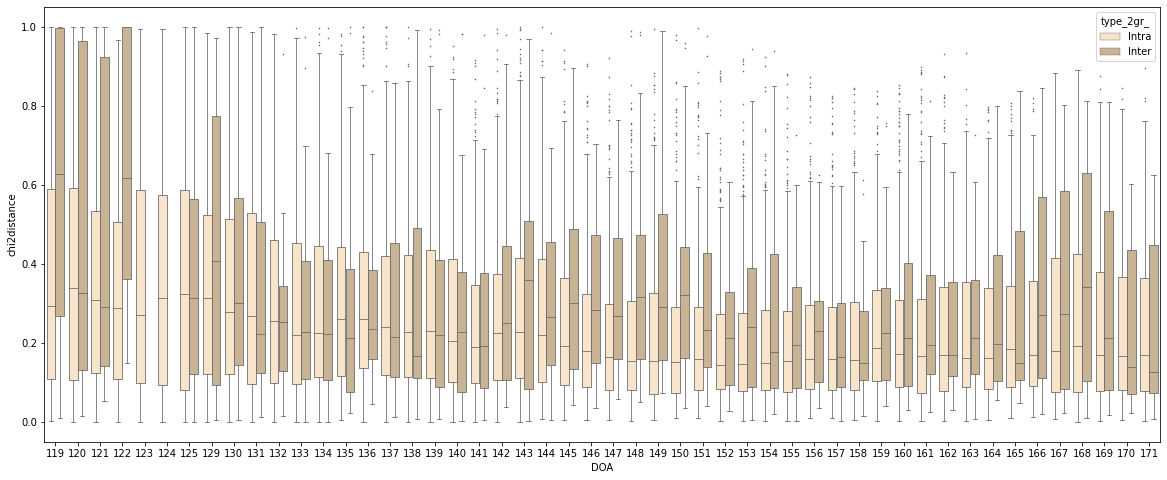

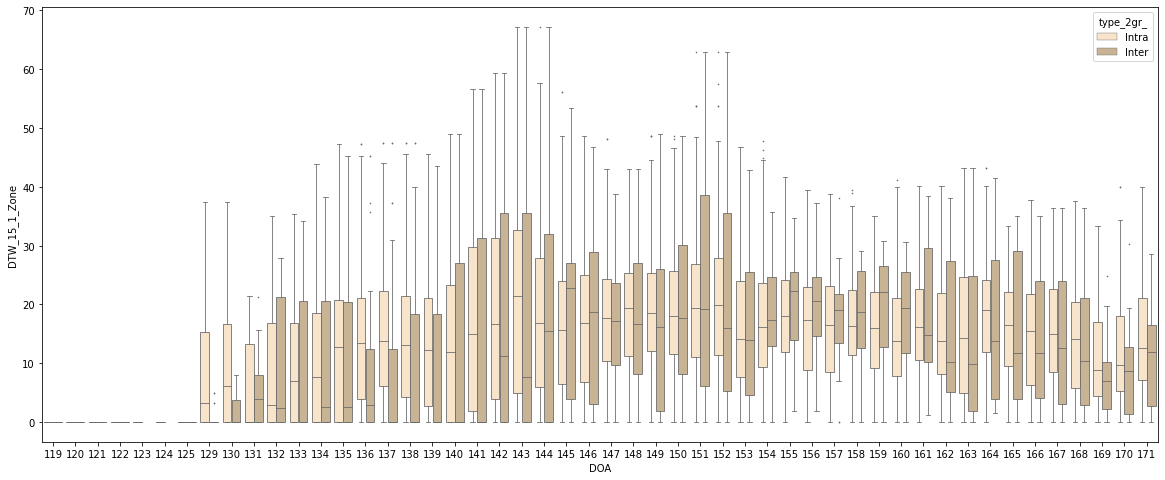

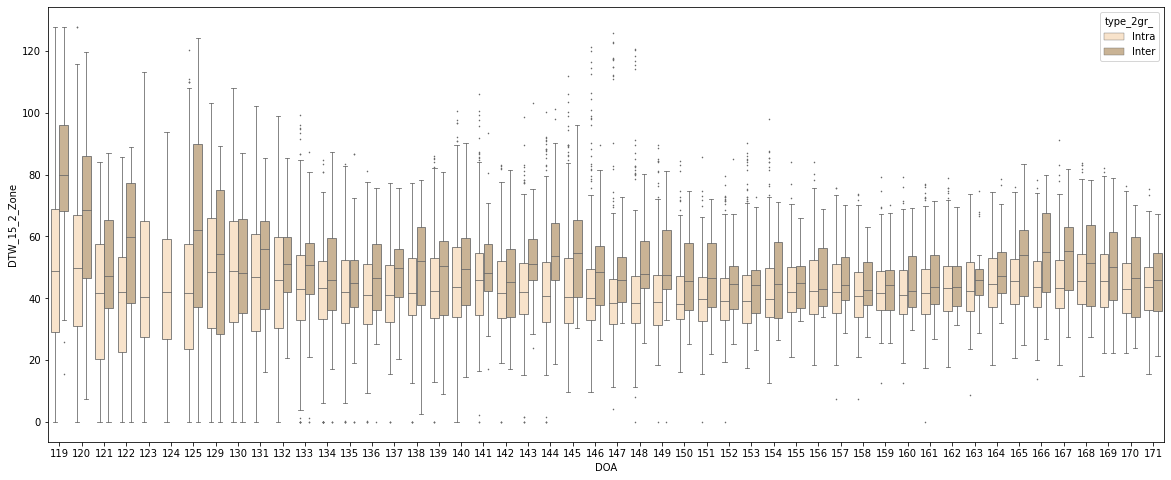

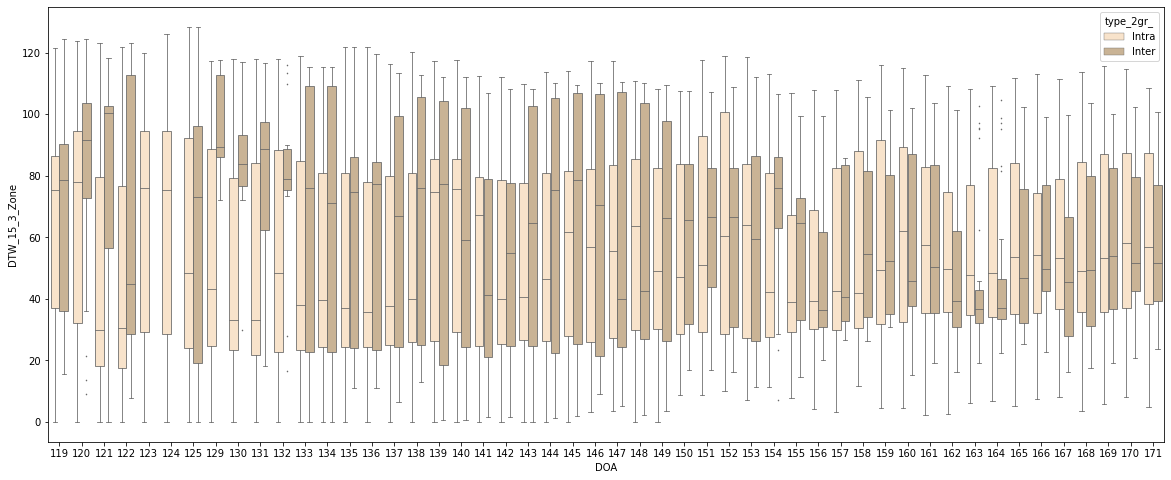

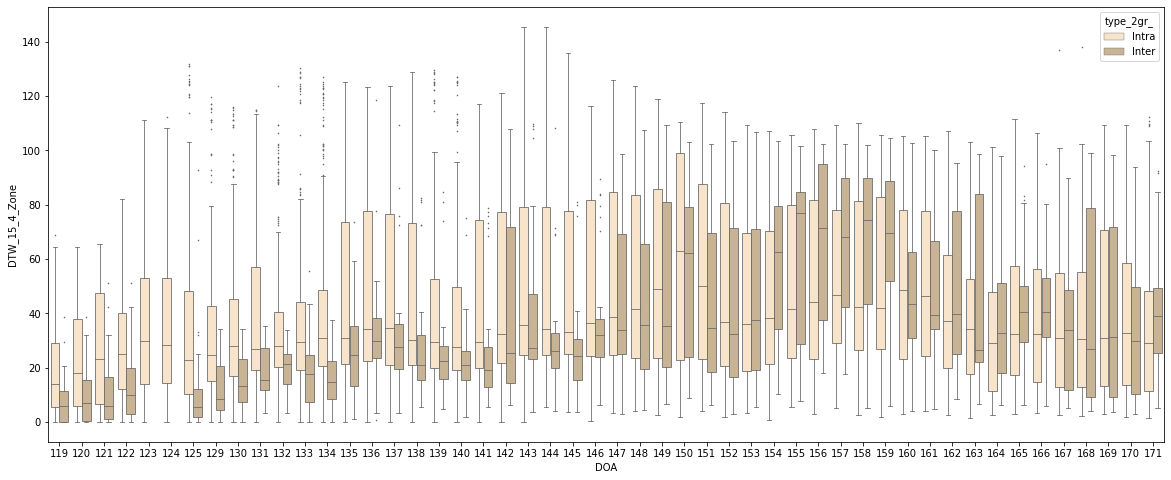

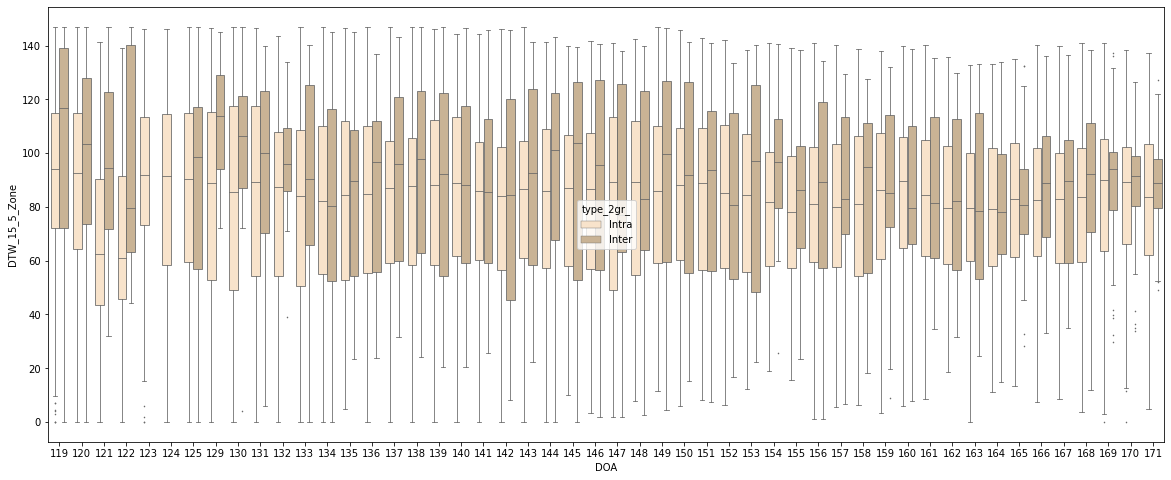

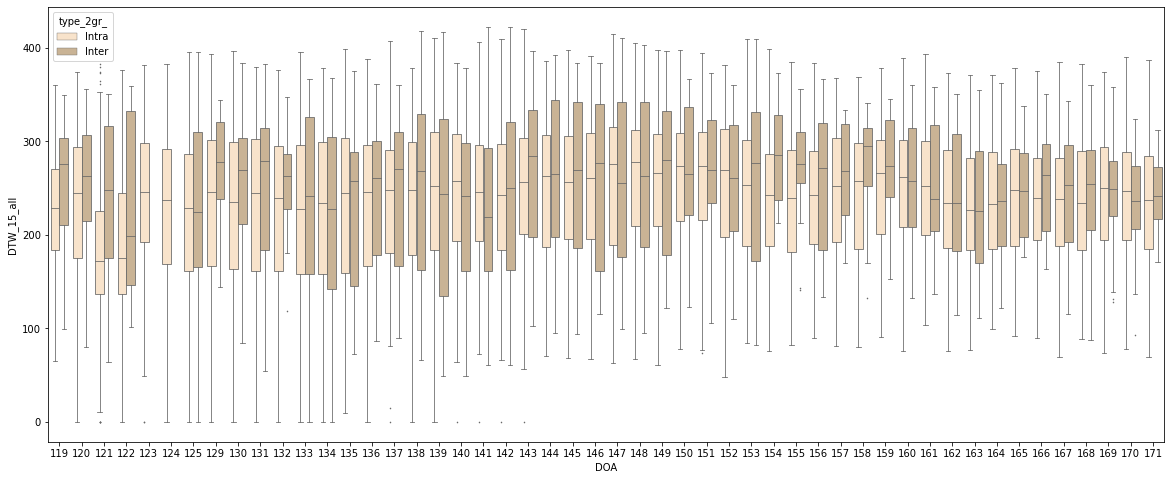

In [16]:
for v in li_dist:
    fig = plt.subplots(figsize=(20,8)) 
    hue_order = ['Intra','Inter']
    sns.boxplot(x="DOA", y=v, hue="type_2gr_", data=df_interintra, 
                linewidth=0.8, fliersize=0.7, palette = {'Intra':'bisque', 'Inter':'tan'}, hue_order=hue_order);
    #plt.savefig(os.path.join(path_extracted_data_visual_adap,'chi2distance_inter&intra_individual_pertreatment_DOA.png'),
    #            dpi=300,format='png',bbox_inches='tight')

# Groups of individuals consistenly more similar?

In [17]:
df_interintra_all['pair'] = df_interintra_all.apply(lambda x: '-'.join(sorted([x['henID1'], x['henID2']])), axis=1)
df_interintra_all['pair'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


hen_135-hen_47     96
hen_135-hen_137    96
hen_139-hen_70     96
hen_46-hen_49      96
hen_131-hen_140    96
                   ..
hen_26-hen_26      37
hen_85-hen_85      37
hen_83-hen_83      37
hen_21-hen_21      37
hen_101-hen_101    37
Name: pair, Length: 1090, dtype: int64

In [18]:
df_phenop = df_interintra_all[df_interintra_all['DOA']>119+30].groupby(['pair','is_same_ind'])['DTW_15_all'].agg(lambda x: list(x)).reset_index()
df_phenop['var'] = df_phenop['DTW_15_all'].map(lambda x: np.var(x))
df_phenop['avg'] = df_phenop['DTW_15_all'].map(lambda x: np.mean(x))
df_phenop['nbr_obs'] = df_phenop['DTW_15_all'].map(lambda x: len(x))
print(df_phenop.shape)
df_phenop.head(3)

(1090, 6)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pair,is_same_ind,DTW_15_all,var,avg,nbr_obs
0,hen_1-hen_1,True,"[144.8, 113.6, 63.00000000000001, 82.199999999...",1825.496302,133.822727,22
1,hen_1-hen_105,False,"[260.5, 342.5, 282.5, 271.1, 293.6, 240.3, 174...",3177.954814,220.513636,44
2,hen_1-hen_106,False,"[240.6, 158.4, 232.2, 216.10000000000002, 229....",3642.688079,264.231818,44


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


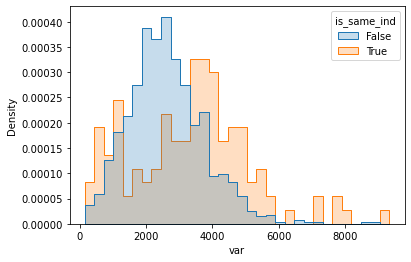

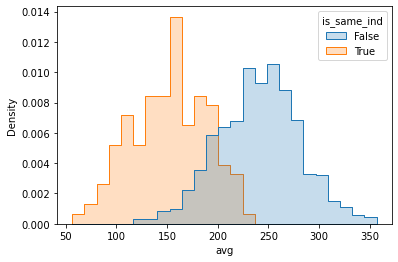

In [19]:
sns.histplot(df_phenop, x="var", hue="is_same_ind", element="step", stat="density", common_norm=False)
plt.show()
sns.histplot(df_phenop, x="avg", hue="is_same_ind", element="step", stat="density", common_norm=False);

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([1140., 1073., 1220., 1371.,  866.,  339.,  116.,   25.,   11.,
           3.]),
 array([  0. ,  15.9,  31.8,  47.7,  63.6,  79.5,  95.4, 111.3, 127.2,
        143.1, 159. ]),
 <BarContainer object of 10 artists>)

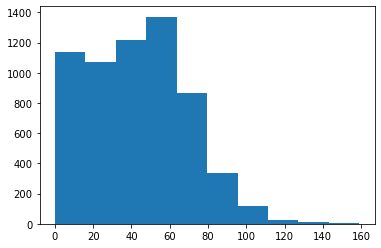

In [29]:
plt.hist(df_daily['Total_number_transition'].tolist());

In [30]:
plt.hist(df_daily['sample_entropy'].tolist())

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: 'sample_entropy'

In [20]:
df_phenop['similar_birds'] = df_phenop.apply(lambda x: (x['var']<3000)&(x['avg']<180), axis=1)
df_phenop['similar_birds'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False    992
True      98
Name: similar_birds, dtype: int64

In [21]:
#keeping the intra difference allows to verify fo rthe technique as well :)
df_phenop[(df_phenop['similar_birds'])&(~df_phenop['is_same_ind'])].head(80)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pair,is_same_ind,DTW_15_all,var,avg,nbr_obs,similar_birds
13,hen_1-hen_5,False,"[143.9, 169.60000000000002, 154.4, 123.9, 126....",2346.637495,175.502273,44,True
51,hen_102-hen_15,False,"[127.4, 152.5, 93.8, 131.2, 87.30000000000001,...",943.507454,124.343182,44,True
52,hen_102-hen_2,False,"[111.0, 95.4, 77.3, 113.4, 104.0, 74.2, 84.0, ...",1149.309711,130.672727,44,True
58,hen_102-hen_81,False,"[129.1, 148.4, 74.0, 147.89999999999998, 105.2...",865.464442,120.368182,44,True
62,hen_102-hen_96,False,"[191.3, 103.10000000000001, 204.09999999999997...",1342.030883,173.684091,44,True
63,hen_102-hen_97,False,"[139.7, 253.39999999999998, 147.39999999999998...",2554.403280,177.761364,44,True
177,hen_110-hen_90,False,"[103.5, 124.5, 211.4, 215.3, 200.7, 266.5, 194...",2769.736999,176.706818,44,True
219,hen_114-hen_116,False,"[52.599999999999994, 90.70000000000002, 102.5,...",2165.625723,143.113636,44,True
221,hen_114-hen_19,False,"[177.1, 257.2, 243.7, 230.6, 242.1000000000000...",1751.706343,178.195455,44,True
222,hen_114-hen_23,False,"[215.3, 205.4, 167.3, 200.10000000000002, 182....",1005.697040,135.852273,44,True


# Basic hen ts visual

In [25]:
li_hens = list(set([i.split('-')[0] for i in df_phenop[(df_phenop['similar_birds'])&(~df_phenop['is_same_ind'])]['pair'].tolist()]+\
[i.split('-')[1] for i in df_phenop[(df_phenop['similar_birds'])&(~df_phenop['is_same_ind'])]['pair'].tolist()]))
print(len(li_hens))

45


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
rv = str(uuid.uuid1())
print(rv)
dico_ = {h:rv for h in li_hens}

6c451a85-7c2a-11eb-a392-089798b63972


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
#choose specific dates to plot, November is better as hens starts to move more and the algo have never seen it
dmin = dt.datetime(2020,10,30)
dmax = dt.datetime(2020,11,23)
#define the cluster dic
ts_visual(df_=df, dmin=dmin, dmax=dmax, dico_h_cl=dico_, path_=path_extracted_data_visual_adap_MVTCLUSTER_tsvisual)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

(215909, 16)


100%|██████████████████████████████████████████████████████████████████████████████| 159/159 [1:00:53<00:00, 22.98s/it]

Total running time: 60.90 mn
